# Reyes, Marcus  2015-89006 EE 298 M-MOZQ

# January 2021

# Final Project EE 298 M

In [1]:
import os
import numpy as np
from scipy import linalg as la
from sklearn.metrics import mean_squared_error
from sklearn import mixture
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

import time

print(os.getcwd())

C:\Users\Marcus\197_proj1\EE298M


In [2]:
#https://github.com/mttk/STL10/blob/master/stl10_input.py

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels

def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images

In [3]:
#Utility codes for processing data

def get_z_codes(optim_z_dim, dataset, B_list):
    z_codes_list = []
    for i in range(3):
        B_m = B_list[i][:,:optim_z_dim].copy()
        z_codes_list.append(np.matmul(dataset[i].copy(), B_m).copy())


    z_codes_uni = np.concatenate((z_codes_list[0],z_codes_list[1],z_codes_list[2]), axis = 1)
    return z_codes_uni

def resize_and_split_data(dataset, train_stride, resize_hw, channels, means_and_stds):
    dataset = np.float32(dataset)
    dataset /= 255
    dataset = dataset[:,::train_stride,::train_stride,:]
    

    dataset[:,:,:,0] -= train_mean_0
    dataset[:,:,:,1] -= train_mean_1
    dataset[:,:,:,2] -= train_mean_2
    dataset[:,:,:,0] /= train_std_0
    dataset[:,:,:,1] /= train_std_1
    dataset[:,:,:,2] /= train_std_2
    X = np.reshape(dataset, (-1, resize_hw*resize_hw*channels))

    X_list = []
    for i in range(channels):
        X_list.append(np.reshape(dataset[:,:,:,i].copy(), (-1,resize_hw*resize_hw*1)))
    return X_list

In [4]:
#Replace with corresponding directories 
train_path = 'stl10_binary/train_X.bin'
train_label_path = 'stl10_binary/train_Y.bin'
test_path = 'stl10_binary/test_X.bin'
test_label_path = 'stl10_binary/test_Y.bin'
unlab_path = 'stl10_binary/unlabeled_X.bin'

In [5]:
start = time.time()
train_im = read_all_images(unlab_path)
train_im = train_im[0:10000]

#So I don't have to keep reloading the dataset if I mess up
backup_im = train_im.copy()
print(train_im.shape)

#Stride of 3
train_stride = 3
#Resulting height and width. (I.e. stride of 2 will results in a height and width of 48)
resize_hw = 32
train_im = train_im[:,::train_stride,::train_stride,:]
orig_im = train_im.copy()
#unlab_im = read_all_images(unlab_path)
print(train_im.shape)
print(train_im.max(), train_im.min())
print("Time elapsed loading datasets", time.time()-start)

(10000, 96, 96, 3)
(10000, 32, 32, 3)
255 0
Time elapsed loading datasets 6.742977619171143


# Sample Images

Load some sample images for reference on how the resized dataset looks like

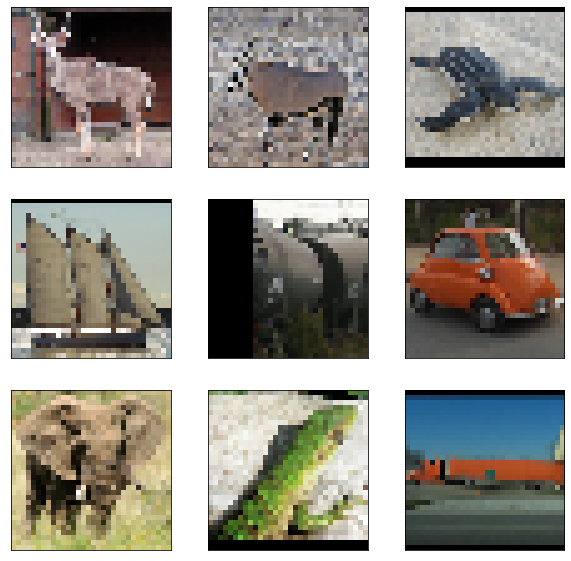

In [6]:
f, axarr = plt.subplots(3,3, figsize = (10,10))
for i,ax in enumerate(axarr.ravel()):
    ax.imshow(train_im[i])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

# Part 1 (PCA)


## Perform Data Centering per channel
Given dataset X = $[x_1, x_2, ..., x_n]$, where each $x_i$ is a datapoint with three channels perform data centering and then divide by the standard deviation per channel

So 

$x_{i, channel j} = x_{i, channel j} - \mu_{i, channel j}$

$x_{i, channel j} = \frac{x_{i, channel j}}{\sigma_{i, channel j}}$

Remember to normalize the data from 0 to 1 before doing mean and standard deviation calculations


In [7]:

#Deprecated flag. Should always be true. Left here for not per channel experimentation purposes
per_channel = True


train_im = np.float32(train_im)
print(train_im.max(), train_im.min())
train_im /= 255
print(train_im.max(), train_im.min())
if per_channel:
    train_mean_0 = np.mean(train_im[:,:,:,0])
    train_mean_1 = np.mean(train_im[:,:,:,1])
    train_mean_2 = np.mean(train_im[:,:,:,2])
    train_im[:,:,:,0] -= train_mean_0
    train_im[:,:,:,1] -= train_mean_1
    train_im[:,:,:,2] -= train_mean_2
    train_std_0 = np.std(train_im[:,:,:,0])
    train_std_1 = np.std(train_im[:,:,:,1])
    train_std_2 = np.std(train_im[:,:,:,2])
    train_im[:,:,:,0] /= train_std_0
    train_im[:,:,:,1] /= train_std_1
    train_im[:,:,:,2] /= train_std_2
else:
    train_mean = np.mean(train_im)
    train_std = np.std(train_im)
    train_im -= train_mean
    train_im /= train_std
print(train_im.shape)
print("Make sure this was not run multiple times. Ensure that min max is 0 and 1")

255.0 0.0
1.0 0.0
(10000, 32, 32, 3)
Make sure this was not run multiple times. Ensure that min max is 0 and 1


## Reshape the dataset for calculation purposes
## Reextract to make sure reshaping was done properly

Sanity check that the dataset was reshaped properly
(10000, 1024)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10000, 32, 32, 3)


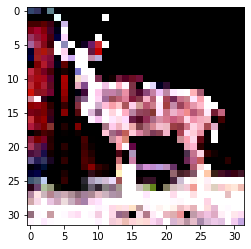

-1.6265266 2.266017
Note the contrast will be off as I have done mean subtraction and division by standard deviation


In [8]:
n_im = train_im.shape[0]
og_shape = train_im.shape
X = np.reshape(train_im, (-1, resize_hw*resize_hw*3))
print("Sanity check that the dataset was reshaped properly")

X_list = []
for i in range(3):
    X_list.append(np.reshape(train_im[:,:,:,i].copy(), (-1,resize_hw*resize_hw*1)))
print(X_list[0].shape)

extract = np.concatenate((X_list[0].reshape(-1,resize_hw,resize_hw,1),X_list[1].reshape(-1,resize_hw,resize_hw,1),X_list[2].reshape(-1,resize_hw,resize_hw,1)),axis = 3)
print(extract.shape)
plt.imshow(np.reshape(extract[0],(resize_hw,resize_hw,3)))
plt.show()
print(extract[0].min(), extract[0].max())
print("Note the contrast will be off as I have done mean subtraction and division by standard deviation")
    

# Obtain the covariance matrix
$S = \frac{XX^T}{N}$

## Decompose the covariance matrix
$S = \frac{XX^T}{N} = DBD^{-1}$

where D are eigenvalues and B are eigenvectors

Note that PCA will be done per channel.


### One PCA per channel will results in three covariance matrices

In [9]:
#Covariance Matrices
print(X_list[0].shape)
S_list = [np.matmul(np.transpose(X_list[i]), X_list[i])/n_im for i in range(3)]

print("Done obtaining S")
print(len(S_list))
print(S_list[0].shape)


(10000, 1024)
Done obtaining S
3
(1024, 1024)


In [10]:
#Obtain eigenvectors
D_list = []
B_list = []
for i, S in enumerate(S_list):
    D,B = la.eig(S, left = True, right = False)
    #Necessary due to numpy's numerical inaccuracies sometimes producing imaginary components
    #https://stackoverflow.com/questions/8765310/scipy-linalg-eig-return-complex-eigenvalues-for-covariance-matrix
    D_list.append(np.real(D))
    B_list.append(np.real(B))

print("Done obtaining eigenvectors")

Done obtaining eigenvectors


# Reconstruction
By taking only the first M principal components we obtain different levels of reconstruction

We thus set $B_m = B[0:M]$ and obtain the reconstruction as follows (in this particular case the reconstruction of the R channel)

$X_{reconstructed, R} = B_mB_{m}^{T}X_{orig}$

$X_{final, R} = \frac{X_{reconstructed} + \mu}{\sigma}$


Then we project back by adding the mean and multiplying by the standard deviation obtained above. Note that this is still done per channel.

Thus the final RGB reconstruction will be 


$X_{final, RGB} = np.stack(X_{final, R}, X_{final, G}, X_{final, B})$

## Load the test dataset for reconstruction

In [11]:
test_path = 'stl10_binary/test_X.bin'
test_stride = train_stride
test_im = read_all_images(test_path)
test_im = test_im[:,::test_stride,::test_stride,:]

test_im = np.float32(test_im)

test_im /= 255
orig_test = test_im.copy()

print(test_im.min(), test_im.max())
if per_channel:
    test_im[:,:,:,0] -= train_mean_0
    test_im[:,:,:,1] -= train_mean_1
    test_im[:,:,:,2] -= train_mean_2
    test_im[:,:,:,0] /= train_std_0
    test_im[:,:,:,1] /= train_std_1
    test_im[:,:,:,2] /= train_std_2

print(test_im.shape)
n_test_im = test_im.shape[0]

X_test_list = []
for i in range(3):
    X_test_list.append(np.reshape(test_im[:,:,:,i], (-1,resize_hw*resize_hw*1)))
print(X_test_list[0].shape)


0.0 1.0
(8000, 32, 32, 3)
(8000, 1024)


In [12]:
#Note that I used powers of 2 for the dim. I suspect the dim_list given by sir had typos
dim_list = [32,64,128,256,512,1024,2048,4096]

mse_list = []
mse_list2 = []
dim_vs_photo_list = []
dim_vs_photo_list2 = []
for i in range(len(dim_list)):
    print("Processing dim", dim_list[i])
    
    R_list = []
    R2_list = []
    for j in range(3):
        B_m = B_list[j][:,:dim_list[i]].copy()
        B_mB_mt = np.matmul(B_m, np.transpose(B_m))
        R_list.append(np.matmul(X_test_list[j].copy(), B_mB_mt))
        R2_list.append(np.matmul(X_list[j].copy(), B_mB_mt))
        

    R = np.concatenate((R_list[0].reshape(-1,resize_hw,resize_hw,1),R_list[1].reshape(-1,resize_hw,resize_hw,1),R_list[2].reshape(-1,resize_hw,resize_hw,1)),axis = 3)
    R = np.reshape(R, (8000,resize_hw,resize_hw,3))
    R2 = np.concatenate((R2_list[0].reshape(-1,resize_hw,resize_hw,1),R2_list[1].reshape(-1,resize_hw,resize_hw,1),R2_list[2].reshape(-1,resize_hw,resize_hw,1)),axis = 3)
    R2 = np.reshape(R2, (10000,resize_hw,resize_hw,3))
    
    R[:,:,:,0] *= train_std_0
    R[:,:,:,1] *= train_std_1
    R[:,:,:,2] *= train_std_2
    R[:,:,:,0] += train_mean_0
    R[:,:,:,1] += train_mean_1
    R[:,:,:,2] += train_mean_2    
    R2[:,:,:,0] *= train_std_0
    R2[:,:,:,1] *= train_std_1
    R2[:,:,:,2] *= train_std_2
    R2[:,:,:,0] += train_mean_0
    R2[:,:,:,1] += train_mean_1
    R2[:,:,:,2] += train_mean_2
    
    
    mse_list.append(((orig_test-R)**2).mean()/8000)
    
    dim_vs_photo_list.append(R2[57])
    dim_vs_photo_list2.append(R[58])

dim_vs_photo_list.append(orig_im[57])
dim_vs_photo_list2.append(orig_test[58])

Processing dim 32
Processing dim 64
Processing dim 128
Processing dim 256
Processing dim 512
Processing dim 1024
Processing dim 2048
Processing dim 4096


## Go through two sample reconstructions 
The left is a reconstruction of a train set sample. The right is a reconstruction of a test set sample
Note that due to computational limitations. a z_dim of 1024 is a lossless reconstruction. Higher dimensions can be achieved by reducing or removing the stride

In [13]:
display_list = []
display_dim_list = [32, 64, 128, 32, 64, 128, 256, 512, 1024, 256, 512, 1024, 2048, 4096, "orig", 2048, 4096, "orig"]
for i in range(0,3):
    display_list.append(dim_vs_photo_list[i])
for i in range(0,3):
    display_list.append(dim_vs_photo_list2[i])
for i in range(3,6):
    display_list.append(dim_vs_photo_list[i])
for i in range(3,6):
    display_list.append(dim_vs_photo_list2[i])
for i in range(6,9):
    display_list.append(dim_vs_photo_list[i])
for i in range(6,9):
    display_list.append(dim_vs_photo_list2[i])
print(display_list[0].shape)

(32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

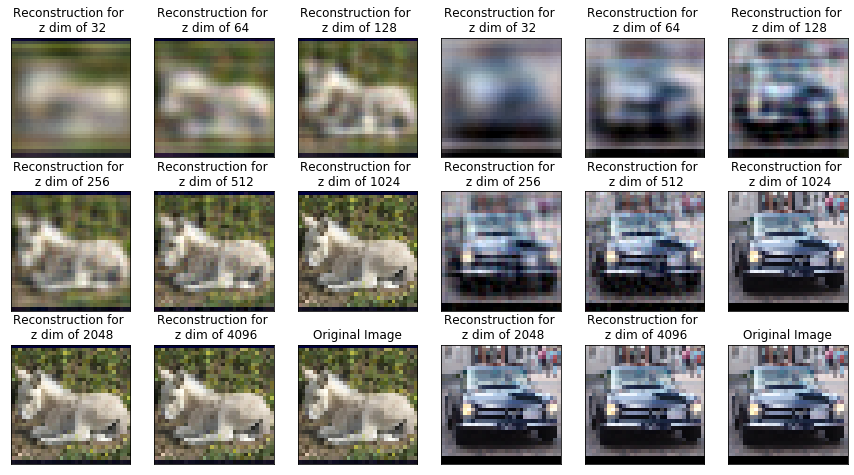

In [14]:
f, axarr = plt.subplots(3,6, figsize = (15,8))
for i,ax in enumerate(axarr.ravel()):
    try:
        ax.imshow(display_list[i])
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 14 or i == 17:
            ax.set_title("Original Image")
        else:
            ax.set_title("Reconstruction for \n z dim of " + str(display_dim_list[i]))
    except IndexError:
        break
plt.show()

## MSE vs z dimension
We plot the MSE between the original image and the reconstructed image per z dimension tried. As expected the MSE decreases as we use a larger z dimension since we lose less information

Note that for our given dimension any z_dim greater than or equal to 1024 is already a lossless reconstruction

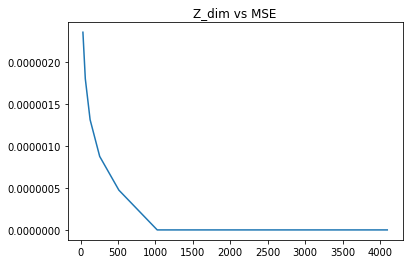

In [15]:
plt.figure()

plt.title("Z_dim vs MSE")
plt.plot(dim_list, mse_list)
plt.show()

### Optimal z-dim
As expected the highest z_dim is the one with the best reconstruction quality
Note that due to the image resizing, at 1024 and above z_dim this is now a lossless reconstruction

I run into memory problems with higher z dimensions thus the "optimal z dimension" will be set to 128


In [16]:
#If more RAM is available this maybe set to a higher dimension
optim_z_dim = 128

#I run into memory errors at higher dimensions
#There seem to be hyperparameters for differnt z_dims

#The following settings were used for z_dim = 128
additive = 1e-300  #1e-200 if z_dim = 64
thresh = 1e-200    #1e-200 if z_dim = 64



# GMM

### Building the dataset from the PCA

From the lecture slides the z code for a given x of the dataset is obtained by multiplying x with $B_m$, where $B_m$ is the first $M$ elements of $B$ in turn obtained via eigenvector decomposition of the covariance matrix

$z = (B_m)^Tx$

Note again we have 3 "channels" of z codes which we concatenate into the final z_code which we try to fit to a GMM

To reconstruct z we just multiply it with $B_m$

$\bar{x} = B_mz$

where $\bar{x}$ is the reconstructed x

In [17]:
z_codes_list = []
for i in range(3):
    B_m = B_list[i][:,:optim_z_dim]
    z_codes_list.append(np.matmul(X_list[i], B_m))
    
print(z_codes_list[0].shape)

z_codes_uni = np.concatenate((z_codes_list[0],z_codes_list[1],z_codes_list[2]), axis = 1)
print(z_codes_uni.shape)

(10000, 128)
(10000, 384)


### GMM Proper

Nothing to delete
For iter:  0 . Time is:  10.543626546859741
For iter:  1 . Time is:  7.118481397628784
For iter:  2 . Time is:  6.340068578720093
For iter:  3 . Time is:  5.6703126430511475
For iter:  4 . Time is:  5.900239706039429
For iter:  5 . Time is:  5.787713527679443
For iter:  6 . Time is:  5.652912855148315
For iter:  7 . Time is:  7.198131322860718
For iter:  8 . Time is:  6.398425579071045
For iter:  9 . Time is:  6.22737979888916
For iter:  10 . Time is:  6.281744480133057
For iter:  11 . Time is:  6.330591201782227
For iter:  12 . Time is:  6.0553789138793945
For iter:  13 . Time is:  5.803380727767944
For iter:  14 . Time is:  5.991526126861572
For iter:  15 . Time is:  6.923551559448242
For iter:  16 . Time is:  6.043784141540527
For iter:  17 . Time is:  5.684814453125
For iter:  18 . Time is:  5.904232978820801
For iter:  19 . Time is:  6.49319314956665
NLL [6906657.594777023, 3978808.0713362447, 3686491.7393556805, 3417079.5071236007, 3212347.1228463277, 3075046.75

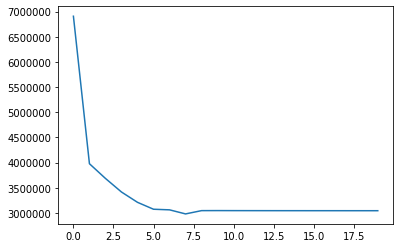

In [18]:
#https://www.python-course.eu/expectation_maximization_and_gaussian_mixture_models.php
#https://github.com/roatienza/ml/blob/master/gmm/notebook/gmm.ipynb
n_comp = 10
n_dim = optim_z_dim*3

try:
    del gmm_sig, gmm_mu, gmm_w, rv, val
except:
    print("Nothing to delete")

start = time.time()
###STEP ONE
#Initialize mean, covariances, and weights of components

gmm_mu = np.random.normal(size = (n_comp, n_dim))
gmm_mu_shape = (n_comp, n_dim)
#Make a covariance matrix for each component similar to sklearn's covariance_type = "full"
gmm_sig = [np.identity(n_dim) for _ in range(n_comp)]
gmm_sig_shape = np.array(gmm_sig).shape

gmm_w = np.ones((n_comp,1))
gmm_w = gmm_w/gmm_w.sum()

iter_max = 20
nll = []

#https://stackoverflow.com/questions/34750845/error-when-testing-whether-a-matrix-is-positive-semi-definite-psd-in-python
#For debugging
def is_semi_pos_def_eigsh(x, epsilon=1e-10):
    return np.all(np.linalg.eigvalsh(x) >= -epsilon)


for iteration in range(iter_max):
    start = time.time()
    
    #Initialize the random gaussians as defined by the mu,sig above
    rv = [multivariate_normal(gmm_mu[i], gmm_sig[i], allow_singular = True) for i in range(n_comp)]
    
    #Probability that z_code belongs to a certain gaussian
    gaussian_prob = np.array([rv[i].pdf(z_codes_uni) for  i in range(n_comp)])
    
    #This additive probability to prevent nans/infs seem to be a hyper paramater
    #1e-200 works for z_dim = 64
    #1e-300 works for z_dim = 128
    gaussian_prob += additive
    
    #How to interpret gaussian_prob
    #Each row contains the probability that each of samples of z_codes belongs to that gaussian
    #I.e. row 3, column 800 is the probability that the 800th sample belongs to the third multivariate gaussian
    
    
    #Get the nll
    weighted_gaussian_prob = np.array([gmm_w[i]*rv[i].pdf(z_codes_uni) for i in range(n_comp)])

    for k in range(n_comp):
        weighted_gaussian_prob[k] = np.array(gmm_w[k]*gaussian_prob[k])
    
    
    #print(weighted_gaussian_prob.min(), weighted_gaussian_prob.max(), "wgp min max")
    
    
    weighted_gaussian_prob = weighted_gaussian_prob.sum(axis = 0)
    
    #print(weighted_gaussian_prob.shape, "shape wgp")
    weighted_gaussian_prob = np.log(weighted_gaussian_prob).sum()
    
    
    nll.append(-weighted_gaussian_prob)
    #-inf because it's too low as of now
    
    #Compute the responsibilities (r_nk)########################################################################
    #r_nk (kn?) = g_val for nth sample and kth gaussian divided by the summation of all gaussians
    #Each weight is repeated for all the samples
    gmm_w_rep = np.repeat(gmm_w, z_codes_uni.shape[0], axis = 1)
    #Multiply each G_prob by its weight
    
    gaussian_prob_sum = (np.multiply(gmm_w_rep, gaussian_prob))
    gaussian_prob_sum = gaussian_prob_sum.sum(axis = 0)
    
    
    #This also seems to be helpful to performance.
    #I forgot to take it out but if it's helpful it'll stay
    gaussian_prob_sum[gaussian_prob_sum < thresh] = thresh
    #(n_samples,) -> (1, n_samples)
    gaussian_prob_sum = np.reshape(gaussian_prob_sum, (-1, gaussian_prob_sum.shape[0]))
    
    #Repeat per component
    gaussian_prob_sum = np.repeat(gaussian_prob_sum, n_comp, axis = 0)
    
    #print("Gaussian_Prob stats", gaussian_prob.min(), gaussian_prob.max())
    #print(gaussian_prob_sum.min(), gaussian_prob_sum.max(), gaussian_prob_sum.shape)
    
    #print("GMM_W_REP", gmm_w_rep.min(), gmm_w_rep.max(), gmm_w_rep.shape)
    #there should be 5000, one for each sample
    
    
    r_nk = np.multiply(gaussian_prob, gmm_w_rep)
    #print(r_nk.shape, "rnk shape")
    
    
    r_nk = np.divide(r_nk, np.sum(r_nk, axis = 0))
    
    #print("RNK should be 0 to 1", r_nk.min(), r_nk.max())
    #print(r_nk.shape, gaussian_prob_sum.shape)
    #print("RNK predivide", r_nk.min(), r_nk.max())
    
    r_nk = np.nan_to_num(r_nk)
     
    #Compute for N_k##########################################3
    if r_nk.sum(axis = 0).min() < 0.9:
        print(r_nk.sum(axis = 0).min())
        print("not one")
        break
    #print("should be one", r_nk.sum(axis = 0).min())
    #print("RNK", r_nk)
    N_k = r_nk.sum(axis = 1)
    #Repeat K times?. I believe it should be dim times
    #go with comp for now
    #changing to dim 408am
    #need to repeat this for each sample to ease the obtaining of others
    N_k = np.repeat(N_k, n_dim, axis = 0)
    
    
    #Update gmm_mu_k

    r_nk = np.repeat(r_nk, n_dim, axis = 0) #r_n?
    
    x_t = [z_codes_uni.transpose() for _ in range(n_comp)]
    x_t = np.concatenate(x_t, axis = 0)
    
    gmm_mu = np.multiply(r_nk, x_t).sum(axis = 1)
    
    gmm_mu = np.divide(gmm_mu, N_k)
    
    gmm_mu = gmm_mu.reshape((-1,1))
    
    
    #Update Covariance Matrices
    x_t = x_t - gmm_mu
    x_tt = x_t.copy()
    
    x_t = np.multiply(x_t, r_nk)
    
    x_t = np.reshape(x_t, (n_comp, n_dim, -1))
    x_tt = np.reshape(x_tt, (n_comp, n_dim, -1))
    
    gmm_sig = [np.matmul(x_t[i], x_tt[i].transpose()) for i in range(x_t.shape[0])]
    
    N_k = np.reshape(N_k, (-1,1))
    
    N_k = np.repeat(N_k, n_dim, axis = 1)
    N_k = np.reshape(N_k, (n_comp, n_dim, n_dim))
    #https://stackoverflow.com/questions/41515522/numpy-positive-semi-definite-warning

    gmm_sig = [np.divide(gmm_sig[i], N_k[i,:,:]) for i in range(n_comp)]
    gmm_sig = np.reshape(np.array(gmm_sig), gmm_sig_shape)
    
    gmm_sig = np.nan_to_num(gmm_sig)
    
    if gmm_sig.max() == 0.0:
        gmm_sig_additive = [1e-10*np.identity(n_dim) for _ in range(n_comp)]
        gmm_sig += gmm_sig_additive
        print("adding")
    
    #Update Weights of each component
    for i in range(n_comp):
        #just get any NK value from that particular matrix
        gmm_w[i] = N_k[i,0,0]/z_codes_uni.shape[0]
    
    #Force the weights to sum to one
    #gmm_w = gmm_w/gmm_w.sum()
    
    #print("################################# sum should be one",gmm_w.sum(axis = 0))
    #shape checks
    gmm_mu = gmm_mu.reshape((gmm_mu_shape))
    
    
    if False:
        #print("for iter", iteration)
        #print("mu:", gmm_mu)
        #print('sigma:', gmm_sig)
        print( N_k[i,0,0])
        print('pi', gmm_w)
    
    end = time.time()
    print("For iter: ",iteration,". Time is: ", end - start)
    #print("___________________________NEXT ITER______________________________________")
    if nll[iteration] < 100 and iteration > 20:
        iter_max = iteration + 1
        print("BREKAING")
        break
x = [iteration for iteration in range(iter_max)]
print("NLL", nll)
print("x", x)
for n in nll:
    n = np.nan_to_num(n)
plt.plot(x, nll)
plt.show()

# Obtaining labels

Obtain the gaussian predictions both for the train set z_codes.

Use the cluster predictions of the GMM to assign labels to the clusters via the following criterion.

Part One: Obtain cluster predictions
1. Decide which GMM component has the greatest weight for a particular z_code
2. Classify that as the prediction for that particular sample

Part Two: Assign labels to the clusters
1. For each class divide them into their cluster predictions. (This will result in a table of size (num_class, num_cluster))
2. For each cluster, label it as the class which has most predictions for that cluster. (Note that each class has exactly 500 in the train set)

### Obtain z_codes from train and test set

In [19]:
test_im = read_all_images(test_path)
train_im = read_all_images(train_path)

train_m_and_s = [train_mean_0, train_mean_1, train_mean_2, train_std_0, train_std_1, train_std_2]

test_X_list = resize_and_split_data(test_im, 3, 32, 3, train_m_and_s)
train_X_list = resize_and_split_data(train_im, 3, 32, 3, train_m_and_s)


test_z_codes = get_z_codes(optim_z_dim, test_X_list, B_list)
train_z_codes = get_z_codes(optim_z_dim, train_X_list, B_list)

print(test_z_codes.shape)
print(train_z_codes.shape)


(8000, 384)
(5000, 384)


In [20]:

rv = [multivariate_normal(gmm_mu[i], gmm_sig[i], allow_singular = True) for i in range(n_comp)]

#Probability that z_code belongs to a certain gaussian
gaussian_prob = np.array([rv[i].pdf(test_z_codes) for  i in range(n_comp)])
gaussian_prob = gaussian_prob.transpose()
print(gaussian_prob.shape)
test_predictions = np.argmax(gaussian_prob, axis = 1)

gaussian_prob = np.array([rv[i].pdf(train_z_codes) for  i in range(n_comp)])
gaussian_prob = gaussian_prob.transpose()
print(gaussian_prob.shape)
train_predictions = np.argmax(gaussian_prob, axis = 1)

print(test_predictions.shape, train_predictions.shape)
print(test_predictions.min(), test_predictions.max())
print(train_predictions.min(), train_predictions.max())
print(test_predictions[0:10],"\n", train_predictions[0:10])

(8000, 10)
(5000, 10)
(8000,) (5000,)
0 9
0 9
[3 8 2 9 8 8 3 2 2 9] 
 [2 0 0 0 2 0 0 2 2 9]


# Comparing with labels

In [21]:
#Obtain the labels
train_labels = read_labels(train_label_path)
train_labels -= 1
#Obtain the indices corresponding to each label
idx_list = []
for i in range(1,11):
    idx_list.append(np.where(train_labels == i)[0])


correct = np.zeros((10,train_labels.shape[0]))
comp = np.zeros((10,train_labels.shape[0]))
final = np.zeros((10,train_labels.shape[0]))
total_pred = np.zeros((10,train_labels.shape[0]))

label_table = np.zeros((10,10))
temp1 = np.zeros((train_labels.shape[0]))
for i in range(10):
    for j in range(10):
        
        temp1 = np.zeros((train_labels.shape[0]))
        temp1[(train_predictions == j) & (train_labels == i)] = 1
        label_table[i][j] = temp1.sum()
        

print(label_table)

[[ 29.   1. 245.  28.   6.   1.   0.   0.  12. 178.]
 [147.   0. 174.  59.   5.   6.   1.   2.  89.  17.]
 [ 76.   0. 163.  47.  13.   2.   1.   0.   8. 190.]
 [ 64.   2. 326.  44.   2.   1.   0.   1.  51.   9.]
 [118.   1. 246.  57.   4.   3.   0.   0.  16.  55.]
 [ 80.   1. 261.  63.   3.   1.   0.   2.  74.  15.]
 [ 73.   0. 258. 111.   4.   3.   1.   2.  23.  25.]
 [114.   0. 280.  59.   0.   1.   1.   1.  40.   4.]
 [ 14.   0. 240.  20.   7.   6.   0.   0.  27. 186.]
 [ 73.   1. 170.  46.  12.   6.   1.   0.  11. 180.]]


In [22]:
import pandas as pd

col_list = []
idx_list = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
for i in range(10):
    col_list.append('Cluster ' + str(i))
print(col_list)
pd.DataFrame(label_table, columns = col_list, index = idx_list)

['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9']


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
airplane,29.0,1.0,245.0,28.0,6.0,1.0,0.0,0.0,12.0,178.0
bird,147.0,0.0,174.0,59.0,5.0,6.0,1.0,2.0,89.0,17.0
car,76.0,0.0,163.0,47.0,13.0,2.0,1.0,0.0,8.0,190.0
cat,64.0,2.0,326.0,44.0,2.0,1.0,0.0,1.0,51.0,9.0
deer,118.0,1.0,246.0,57.0,4.0,3.0,0.0,0.0,16.0,55.0
dog,80.0,1.0,261.0,63.0,3.0,1.0,0.0,2.0,74.0,15.0
horse,73.0,0.0,258.0,111.0,4.0,3.0,1.0,2.0,23.0,25.0
monkey,114.0,0.0,280.0,59.0,0.0,1.0,1.0,1.0,40.0,4.0
ship,14.0,0.0,240.0,20.0,7.0,6.0,0.0,0.0,27.0,186.0
truck,73.0,1.0,170.0,46.0,12.0,6.0,1.0,0.0,11.0,180.0


Now we assign labels to the clusters. For each cluster we take the class that has the most predictions and label it as that cluster.

In [23]:
named_cluster_dict = {}
number_cluster_dict = {}
for i in range(10):
    named_cluster_dict[i] = idx_list[np.argmax(label_table[:,i])]


for i in range(10):
    number_cluster_dict[i] = np.argmax(label_table[:,i])
print(named_cluster_dict)
print(number_cluster_dict)

{0: 'bird', 1: 'cat', 2: 'cat', 3: 'horse', 4: 'car', 5: 'bird', 6: 'bird', 7: 'bird', 8: 'bird', 9: 'car'}
{0: 1, 1: 3, 2: 3, 3: 6, 4: 2, 5: 1, 6: 1, 7: 1, 8: 1, 9: 2}


In [24]:
#Edit the test predictions from before
#https://stackoverflow.com/questions/3403973/fast-replacement-of-values-in-a-numpy-array
test_predictions_converted = np.copy(test_predictions)
for k, v in number_cluster_dict.items(): test_predictions_converted[test_predictions == k] = v
print(test_predictions)
print(test_predictions_converted)

[3 8 2 ... 8 9 9]
[6 1 3 ... 1 2 2]


In [25]:
#Obtain the test labels
test_labels = read_labels(test_label_path)
test_labels -= 1
#Obtain the indices corresponding to each label
idx_list = []
for i in range(1,11):
    idx_list.append(np.where(test_labels == i)[0])


correct = np.zeros((10,test_labels.shape[0]))
comp = np.zeros((10,test_labels.shape[0]))
final = np.zeros((10,test_labels.shape[0]))
total_pred = np.zeros((10,test_labels.shape[0]))

label_table2 = np.zeros((10,10))
temp1 = np.zeros((test_labels.shape[0]))
for i in range(10):
    for j in range(10):
        
        temp1 = np.zeros((test_labels.shape[0]))
        temp1[(test_predictions == j) & (test_labels == i)] = 1
        label_table2[i][j] = temp1.sum()
        

print(label_table2)
print(label_table2.sum(axis = 1), label_table2.sum(axis = 0))

[[ 30.   2. 446.  25.  10.   3.   2.   0.  15. 267.]
 [231.   2. 307. 107.   4.  10.   2.   3. 113.  21.]
 [126.   0. 249.  88.  25.   9.   1.   1.   8. 293.]
 [110.   2. 482.  98.   1.   1.   0.   0.  89.  17.]
 [206.   0. 391.  76.   8.   2.   1.   0.  33.  83.]
 [146.   3. 391. 110.   2.   7.   1.   1. 112.  27.]
 [134.   0. 398. 167.   2.   3.   2.   1.  45.  48.]
 [189.   0. 432.  88.   1.   3.   1.   2.  78.   6.]
 [ 21.   4. 351.  34.   9.   2.   0.   1.  39. 339.]
 [ 97.   1. 275.  69.  27.   3.   1.   1.  20. 306.]]
[800. 800. 800. 800. 800. 800. 800. 800. 800. 800.] [1290.   14. 3722.  862.   89.   43.   11.   10.  552. 1407.]


In [26]:
col_list = []
for i in range(10):
    col_list.append("Cluster " + str(named_cluster_dict[i]))
idx_list = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
print(idx_list)
print(col_list)
pd.DataFrame(label_table2, columns = col_list, index = idx_list)

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
['Cluster bird', 'Cluster cat', 'Cluster cat', 'Cluster horse', 'Cluster car', 'Cluster bird', 'Cluster bird', 'Cluster bird', 'Cluster bird', 'Cluster car']


,Cluster bird,Cluster cat,Cluster cat,Cluster horse,Cluster car,Cluster bird,Cluster bird,Cluster bird,Cluster bird,Cluster car
airplane,30.0,2.0,446.0,25.0,10.0,3.0,2.0,0.0,15.0,267.0
bird,231.0,2.0,307.0,107.0,4.0,10.0,2.0,3.0,113.0,21.0
car,126.0,0.0,249.0,88.0,25.0,9.0,1.0,1.0,8.0,293.0
cat,110.0,2.0,482.0,98.0,1.0,1.0,0.0,0.0,89.0,17.0
deer,206.0,0.0,391.0,76.0,8.0,2.0,1.0,0.0,33.0,83.0
dog,146.0,3.0,391.0,110.0,2.0,7.0,1.0,1.0,112.0,27.0
horse,134.0,0.0,398.0,167.0,2.0,3.0,2.0,1.0,45.0,48.0
monkey,189.0,0.0,432.0,88.0,1.0,3.0,1.0,2.0,78.0,6.0
ship,21.0,4.0,351.0,34.0,9.0,2.0,0.0,1.0,39.0,339.0
truck,97.0,1.0,275.0,69.0,27.0,3.0,1.0,1.0,20.0,306.0


Note that sometimes a label is chosen to be assigned to two clusters. That is a limitation of the method of assigning labels.
The total accuracy then is how many classes are assigned to the properly named clusters divided by the total amount of the dataset

In [27]:
total_correct = np.zeros((test_labels.shape[0]))
print(test_predictions_converted.shape, test_labels.shape)
total_correct[test_predictions_converted == test_labels] = 1
gmm_scratch_accuracy = total_correct.sum()/test_labels.shape
print("Final accuracy: ",total_correct.sum()/test_labels.shape)

(8000,) (8000,)
Final accuracy:  [0.166]


While not exactly high, the accuracy is still better than pure random which is expected to be 10% or num_classes/total_classes

(Runs seem to make this vary from ~15-20%)

# GMM Reproduction attempt

In [28]:

rv = [multivariate_normal(gmm_mu[i], gmm_sig[i], allow_singular = True) for i in range(n_comp)]
final_sample = 0
sample_amount = 100
for i in range(n_comp):
    final_sample += gmm_w[i]*(rv[i].rvs(sample_amount))
    
print(final_sample.shape)
print(rv[0].rvs(10).shape)

(100, 384)
(10, 384)


Processing dim 128


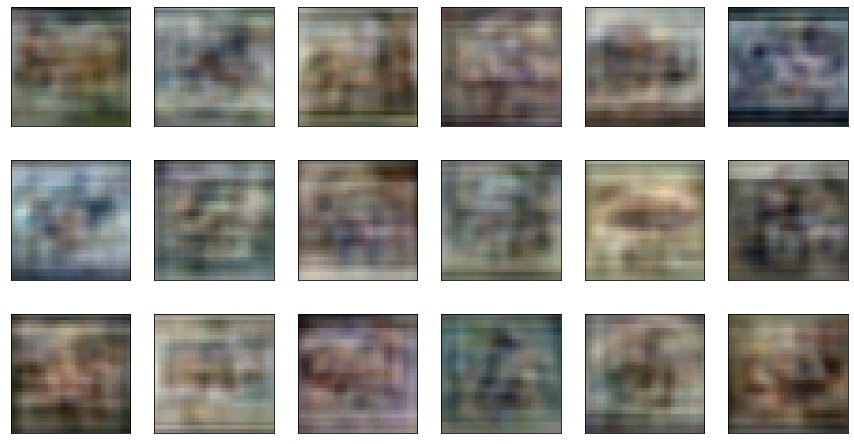

In [29]:
#Note that I used powers of 2 for the dim. I suspect the dim_list given by sir had typos
dim_list = [optim_z_dim]

print("Processing dim", dim_list[0])

R_list = []
for j in range(3):
    B_m_sample = B_list[j][:,:dim_list[0]].copy()
    R_list.append(np.matmul(final_sample[:,optim_z_dim*j:optim_z_dim*(j+1)],B_m_sample.transpose()))


R = np.concatenate((R_list[0].reshape(-1,resize_hw,resize_hw,1),R_list[1].reshape(-1,resize_hw,resize_hw,1),R_list[2].reshape(-1,resize_hw,resize_hw,1)),axis = 3)
R = np.reshape(R, (100,resize_hw,resize_hw,3))

R[:,:,:,0] *= train_std_0
R[:,:,:,1] *= train_std_1
R[:,:,:,2] *= train_std_2
R[:,:,:,0] += train_mean_0
R[:,:,:,1] += train_mean_1
R[:,:,:,2] += train_mean_2    


f, axarr = plt.subplots(3,6, figsize = (15,8))
for i,ax in enumerate(axarr.ravel()):
    try:
        ax.imshow(R[i])
        ax.set_xticks([])
        ax.set_yticks([])
    except IndexError:
        break
plt.show()



# Why GMM did not work very well? Experimental/Tentaive Justification

When I tried to use GMM on MNIST it took 500 components to be able to generate a sample I suspect this has somethign to do with the limitations of my GMM's performance. Here I use mixture.GMM

In [30]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_train) = mnist.load_data()

idx = np.random.randint(0, 60000, size = 10000)
x_train = x_train[idx]
del x_test
x_train = np.float32(x_train)/255

In [31]:
x_mean = np.mean(x_train)
x_std = np.std(x_train)
x_train -= x_mean
x_train /= x_std

In [32]:
x_train = np.reshape(x_train, (-1,28*28))
#Covariance Matrix
S_x = np.matmul(np.transpose(x_train), x_train)/10000
print("Done obtaining S")
#Obtain eigenvectors
D_x,B_x = la.eig(S_x, left = True, right = False)

D_x, B_x = np.real(D_x), np.real(B_x)

Done obtaining S


In [33]:
# Obtain Mnist Zcodes
B_mx = np.real(B_x)[:,:512].copy()
x_z_codes = np.matmul(x_train, B_mx)
x_z_codes = x_z_codes.transpose()

In [34]:
scikit_10 = mixture.GaussianMixture(n_components = 10, covariance_type = 'spherical', max_iter = 100, tol = 0.001, random_state = 0)
scikit_10.fit(x_z_codes.transpose())

scikit_100 = mixture.GaussianMixture(n_components = 100, covariance_type = 'spherical', max_iter = 100, tol = 0.001, random_state = 0)
scikit_100.fit(x_z_codes.transpose())

scikit_500 = mixture.GaussianMixture(n_components = 500, covariance_type = 'spherical', max_iter = 100, tol = 0.001, random_state = 0)
scikit_500.fit(x_z_codes.transpose())
print("Done fitting")

Done fitting


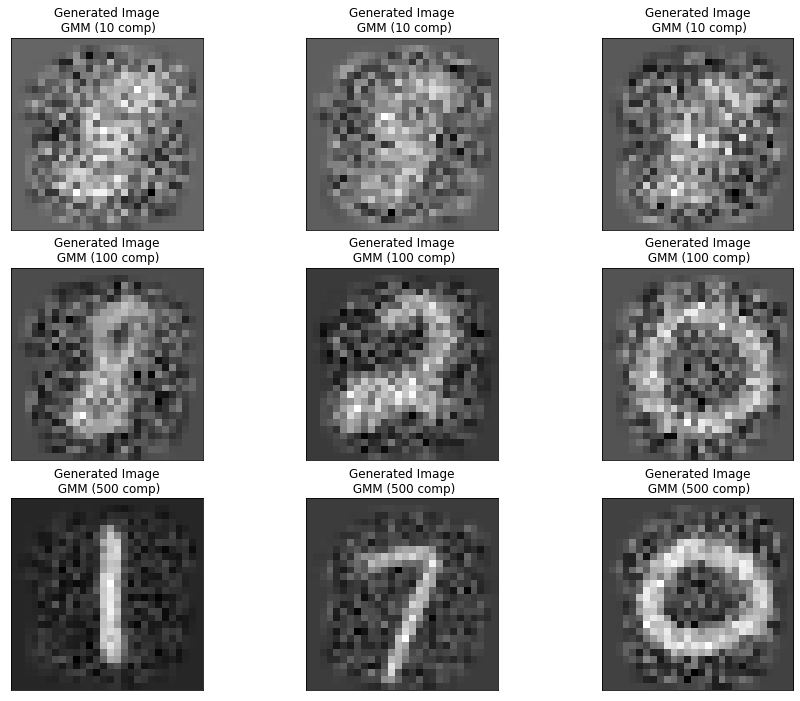

In [35]:
sample_10, _ = scikit_10.sample(100)
sample_100, _ = scikit_100.sample(100)
sample_500, _ = scikit_500.sample(100)



new_image_10 = np.matmul(sample_10[0],B_mx.transpose())
new_image_100 = np.matmul(sample_100[0],B_mx.transpose())
new_image_500 = np.matmul(sample_500[0],B_mx.transpose())

new_images_list = []
new_images_list.append(np.matmul(sample_10[0],B_mx.transpose()))
new_images_list.append(np.matmul(sample_10[5],B_mx.transpose()))
new_images_list.append(np.matmul(sample_10[7],B_mx.transpose()))
new_images_list.append(np.matmul(sample_100[0],B_mx.transpose()))
new_images_list.append(np.matmul(sample_100[5],B_mx.transpose()))
new_images_list.append(np.matmul(sample_100[7],B_mx.transpose()))
new_images_list.append(np.matmul(sample_500[0],B_mx.transpose()))
new_images_list.append(np.matmul(sample_500[5],B_mx.transpose()))
new_images_list.append(np.matmul(sample_500[7],B_mx.transpose()))
f, axarr = plt.subplots(3,3, figsize = (15,12))
for i,ax in enumerate(axarr.ravel()):
    ax.imshow(new_images_list[i].reshape((28,28)), cmap = 'gray')
    ax.set_xticks([])
    ax.set_yticks([])
    
    if i < 3:
        ax.set_title("Generated Image\n GMM (10 comp)")
    elif i < 6:
        
        ax.set_title("Generated Image\n GMM (100 comp)")
    else:
        ax.set_title("Generated Image\n GMM (500 comp)")
        
        
plt.show()

As can be seen the generative model at a GMM of 10 components is practically just noise, when compared to the one with hundreds of components. It seems then that a GMM of 10 components is not enough to accurately make a generator for STL. Note that even the higher dimensions are struggling possibly because I am using a low z dimensions

# Using mixture.Gaussian to predict
## Warning: Some variable names are reused it would be best not to rerun anything above once you get past this point. Either that or rerun the entire thing

In [36]:
scikit_10 = mixture.GaussianMixture(n_components = 10, covariance_type = 'full', max_iter = 100, tol = 0.001, random_state = 0)
scikit_10.fit(z_codes_uni)
a = -10000*scikit_10.score(z_codes_uni)
print(a)
print(a/-10000)


3045772.220657246
-304.57722206572464


In [37]:

print(train_z_codes.shape)
train_predictions = scikit_10.predict(train_z_codes)
print(train_predictions.shape)
print(train_predictions.min(), train_predictions.max())
test_predictions = scikit_10.predict(test_z_codes)

(5000, 384)
(5000,)
0 9


In [38]:
#Obtain the labels
train_labels = read_labels(train_label_path)
train_labels -= 1
#Obtain the indices corresponding to each label
idx_list = []
for i in range(1,11):
    idx_list.append(np.where(train_labels == i)[0])


correct = np.zeros((10,train_labels.shape[0]))
comp = np.zeros((10,train_labels.shape[0]))
final = np.zeros((10,train_labels.shape[0]))
total_pred = np.zeros((10,train_labels.shape[0]))

label_table = np.zeros((10,10))
temp1 = np.zeros((train_labels.shape[0]))
for i in range(10):
    for j in range(10):
        
        temp1 = np.zeros((train_labels.shape[0]))
        temp1[(train_predictions == j) & (train_labels == i)] = 1
        label_table[i][j] = temp1.sum()
        

print(label_table)

[[  8.  12.  31. 236.  45.  64.  55.   1.   7.  41.]
 [113.   1.   0. 122. 104.   1. 151.   2.   2.   4.]
 [ 36.   3.  26.  86.  30. 114.  87.   8.   5. 105.]
 [110.   0.   0. 256.  40.   0.  84.   2.   5.   3.]
 [176.   0.   0. 149.  68.   0.  86.   2.   9.  10.]
 [ 90.   1.   0. 201.  68.   0. 132.   0.   5.   3.]
 [124.   0.   0. 152.  94.   0. 104.   4.   9.  13.]
 [135.   3.   0. 170.  70.   0. 115.   1.   2.   4.]
 [  6.  22. 121. 160.  23.  61.  60.   0.   3.  44.]
 [ 25.   7.  53.  97.  39.  92.  81.   1.   3. 102.]]


In [39]:
import pandas as pd

col_list = []
idx_list = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
for i in range(10):
    col_list.append('Cluster ' + str(i))
print(col_list)
pd.DataFrame(label_table, columns = col_list, index = idx_list)

['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9']


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
airplane,8.0,12.0,31.0,236.0,45.0,64.0,55.0,1.0,7.0,41.0
bird,113.0,1.0,0.0,122.0,104.0,1.0,151.0,2.0,2.0,4.0
car,36.0,3.0,26.0,86.0,30.0,114.0,87.0,8.0,5.0,105.0
cat,110.0,0.0,0.0,256.0,40.0,0.0,84.0,2.0,5.0,3.0
deer,176.0,0.0,0.0,149.0,68.0,0.0,86.0,2.0,9.0,10.0
dog,90.0,1.0,0.0,201.0,68.0,0.0,132.0,0.0,5.0,3.0
horse,124.0,0.0,0.0,152.0,94.0,0.0,104.0,4.0,9.0,13.0
monkey,135.0,3.0,0.0,170.0,70.0,0.0,115.0,1.0,2.0,4.0
ship,6.0,22.0,121.0,160.0,23.0,61.0,60.0,0.0,3.0,44.0
truck,25.0,7.0,53.0,97.0,39.0,92.0,81.0,1.0,3.0,102.0


Now we assign labels to the clusters. For each cluster we take the class that has the most predictions and label it as that cluster.

In [40]:
named_cluster_dict = {}
number_cluster_dict = {}
for i in range(10):
    named_cluster_dict[i] = idx_list[np.argmax(label_table[:,i])]


for i in range(10):
    number_cluster_dict[i] = np.argmax(label_table[:,i])
print(named_cluster_dict)
print(number_cluster_dict)

{0: 'deer', 1: 'ship', 2: 'ship', 3: 'cat', 4: 'bird', 5: 'car', 6: 'bird', 7: 'car', 8: 'deer', 9: 'car'}
{0: 4, 1: 8, 2: 8, 3: 3, 4: 1, 5: 2, 6: 1, 7: 2, 8: 4, 9: 2}


In [41]:
#Edit the test predictions from before
#https://stackoverflow.com/questions/3403973/fast-replacement-of-values-in-a-numpy-array
test_predictions_converted = np.copy(test_predictions)
for k, v in number_cluster_dict.items(): test_predictions_converted[test_predictions == k] = v
print(test_predictions)
print(test_predictions_converted)

[0 6 3 ... 6 5 3]
[4 1 3 ... 1 2 3]


In [42]:
#Obtain the test labels
test_labels = read_labels(test_label_path)
test_labels -= 1
#Obtain the indices corresponding to each label
idx_list = []
for i in range(1,11):
    idx_list.append(np.where(test_labels == i)[0])


correct = np.zeros((10,test_labels.shape[0]))
comp = np.zeros((10,test_labels.shape[0]))
final = np.zeros((10,test_labels.shape[0]))
total_pred = np.zeros((10,test_labels.shape[0]))

label_table2 = np.zeros((10,10))
temp1 = np.zeros((test_labels.shape[0]))
for i in range(10):
    for j in range(10):
        
        temp1 = np.zeros((test_labels.shape[0]))
        temp1[(test_predictions == j) & (test_labels == i)] = 1
        label_table2[i][j] = temp1.sum()
        

print(label_table2)
print(label_table2.sum(axis = 1), label_table2.sum(axis = 0))

[[ 22.  14.  71. 410.  71.  60.  70.   2.   6.  74.]
 [166.   5.   0. 233. 161.   0. 217.   2.   3.  13.]
 [ 38.   6.  50. 141.  37. 185. 144.   8.   7. 184.]
 [163.   0.   0. 383.  74.   1. 160.   5.   4.  10.]
 [239.   2.   0. 263.  93.   3. 169.   3.  17.  11.]
 [178.   1.   0. 301.  81.   0. 220.   2.   9.   8.]
 [209.   1.   0. 228. 144.   2. 170.   6.  15.  25.]
 [235.   1.   0. 280.  82.   0. 178.   9.   9.   6.]
 [ 10.  24. 206. 236.  29. 131.  86.   1.   5.  72.]
 [ 32.  15.  88. 150.  56. 161. 116.   8.   6. 168.]]
[800. 800. 800. 800. 800. 800. 800. 800. 800. 800.] [1292.   69.  415. 2625.  828.  543. 1530.   46.   81.  571.]


In [43]:
col_list = []
for i in range(10):
    col_list.append("Cluster " + str(named_cluster_dict[i]))
idx_list = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
print(idx_list)
print(col_list)
pd.DataFrame(label_table2, columns = col_list, index = idx_list)

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
['Cluster deer', 'Cluster ship', 'Cluster ship', 'Cluster cat', 'Cluster bird', 'Cluster car', 'Cluster bird', 'Cluster car', 'Cluster deer', 'Cluster car']


,Cluster deer,Cluster ship,Cluster ship,Cluster cat,Cluster bird,Cluster car,Cluster bird,Cluster car,Cluster deer,Cluster car
airplane,22.0,14.0,71.0,410.0,71.0,60.0,70.0,2.0,6.0,74.0
bird,166.0,5.0,0.0,233.0,161.0,0.0,217.0,2.0,3.0,13.0
car,38.0,6.0,50.0,141.0,37.0,185.0,144.0,8.0,7.0,184.0
cat,163.0,0.0,0.0,383.0,74.0,1.0,160.0,5.0,4.0,10.0
deer,239.0,2.0,0.0,263.0,93.0,3.0,169.0,3.0,17.0,11.0
dog,178.0,1.0,0.0,301.0,81.0,0.0,220.0,2.0,9.0,8.0
horse,209.0,1.0,0.0,228.0,144.0,2.0,170.0,6.0,15.0,25.0
monkey,235.0,1.0,0.0,280.0,82.0,0.0,178.0,9.0,9.0,6.0
ship,10.0,24.0,206.0,236.0,29.0,131.0,86.0,1.0,5.0,72.0
truck,32.0,15.0,88.0,150.0,56.0,161.0,116.0,8.0,6.0,168.0


Note that sometimes a label is chosen to be assigned to two clusters. That is a limitation of the method of assigning labels.
The total accuracy then is how many classes are assigned to the properly named clusters divided by the total amount of the dataset

In [44]:
total_correct = np.zeros((test_labels.shape[0]))
print(test_predictions_converted.shape, test_labels.shape)
total_correct[test_predictions_converted == test_labels] = 1
print("Final accuracy: ",total_correct.sum()/test_labels.shape)

(8000,) (8000,)
Final accuracy:  [0.203]


In [45]:
#Compare the accuracy of the two
print("SKLearn accuracy: ",total_correct.sum()/test_labels.shape)
print("GMM from scratch accuracy: ",gmm_scratch_accuracy)
print("Accuracies seem to vary per from both approximately range ~15-20%")

SKLearn accuracy:  [0.203]
GMM from scratch accuracy:  [0.166]
Accuracies seem to vary per from both approximately range ~15-20%


In [46]:
#Compare the NLL
#.score seems to be log likelihood avreage from the source code. Thus multiply by negative dataset size
a = -10000*scikit_10.score(z_codes_uni)
gmm_nll = nll[-1]

print("sklearn nll: ", a, " vs gmm nll: ", gmm_nll)

sklearn nll:  3045772.220657246  vs gmm nll:  3045762.078381017


### Note that the accuracy and nll are at around the same level
### Note also that the nll for the gmm from scratch one may be skewed by the additive probability I used to prevent nans/infs